In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier
# XGBoost 
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

mycmap = "winter"
mpl.rcParams['image.cmap'] = mycmap
plt.rcParams['font.size'] = 13

XGBoost version: 2.1.3


In [3]:
np.random.seed(12345)

dname="./DATA/"
str0="_XGB_25.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)
N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
print(f"N={N}, N_train={N_train}, L={L}")

N=5000, N_train=3750, L=4


[-31.608 -29.544   6.773   9.554] 0
[46.451 15.318 24.891 15.357] 0
[ 24.771  46.131 -49.161 -39.356] 0
[-20.13   15.641  30.981  37.218] 0
[46.465 22.369 14.248 21.745] 0


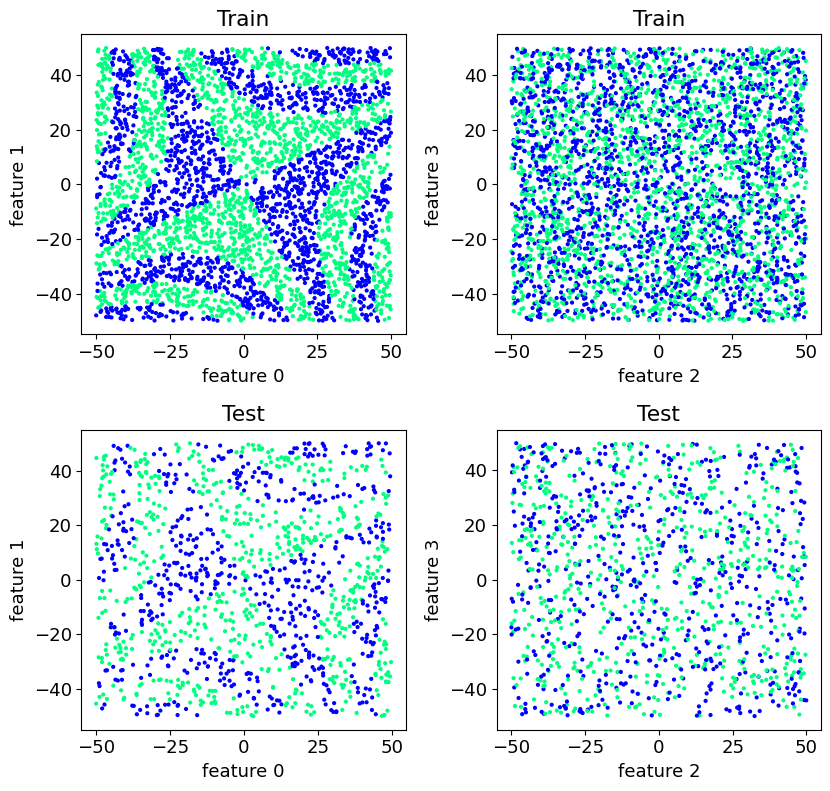

In [5]:
def scat(ax,x,y,i=0,j=1,s=4,title=""):
    ax.scatter(x[:,i],x[:,j],s=s,c=y)
    ax.set_xlabel(f"feature {i}")
    ax.set_ylabel(f"feature {j}")
    ax.set_title(title)


for n in range(5):
    print(x[n],y[n])

fig,AX = plt.subplots(2,2,figsize=(8.5,8.1))
scat(AX[0,0],x_train,y_train,title="Train")
scat(AX[0,1],x_train,y_train,i=2,j=3,title="Train")
scat(AX[1,0],x_test,y_test,title="Test")
scat(AX[1,1],x_test,y_test,i=2,j=3,title="Test")
fig.tight_layout()
plt.show()

In [9]:
def classify( x_train, y_train, x_test, y_test, L, clf=GradientBoostingClassifier(), show=False):  
    
    # GradientBoostingClassifier():
    #   n_estimators = 100 (default)
    #   loss function = deviance(default) used in Logistic Regression
    # XGBClassifier()
    #   n_estimators = 100 (default)
    #   max_depth = 3 (default?)
    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_test)
    
    print("errors: {:.2f}%   Accuracy={:.5f}".format(100*(1-clf.score(x_test, y_test)),clf.score(x_test, y_test)))

    S=50
    dx = 1
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,L))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:2] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot) 

    fig,AX = plt.subplots(1,2,figsize=(8.2,4))
    scat(AX[0],x_plot[:],y_plot,s=dx,title="predicted")
    scat(AX[1],x_train[:],y_train,title="training set")
    fig.tight_layout()
    plt.show()
    
    if show:   
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(2,1,figsize=(12, 5))
        for i in range(min(2,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=400, pad_inches=0.02)   
        plt.show()

### Classify
If the “objective” hyperparameter is left unspecified, XGBClassifier looks at the data and chooses automatically the loss functions and the evaluation metrics (--> WARNING)

## XGBoost
https://xgboost.readthedocs.io/en/stable/python/python_api.html

errors: 6.64%   Accuracy=0.93360


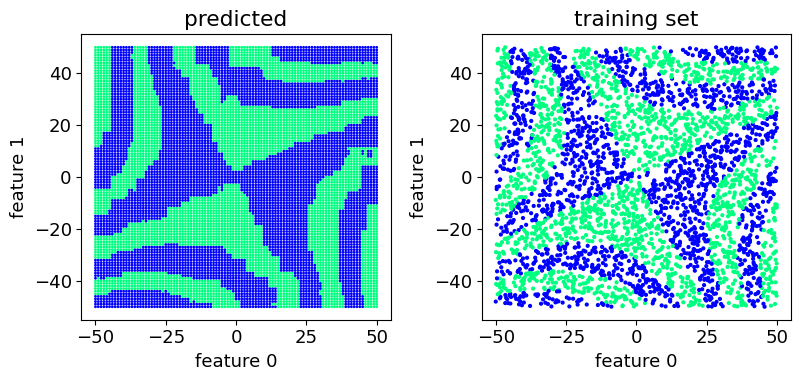

In [11]:
model = XGBClassifier(seed=1,
                      objective='binary:logistic',
                      importance_type="gain") #weight, cover, ...
       # learning_rate=0.4,
       # reg_lambda=0.001, 
       # n_estimators=30)

classify(x_train, y_train, x_test, y_test, 4, model, show=False) 

gain
[0.41903338 0.4430613  0.06554136 0.07236398]


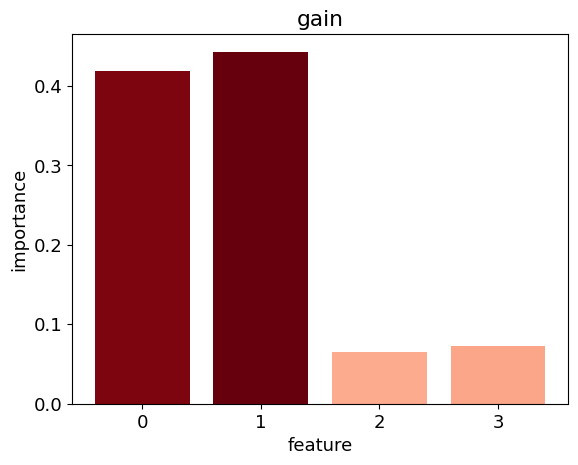

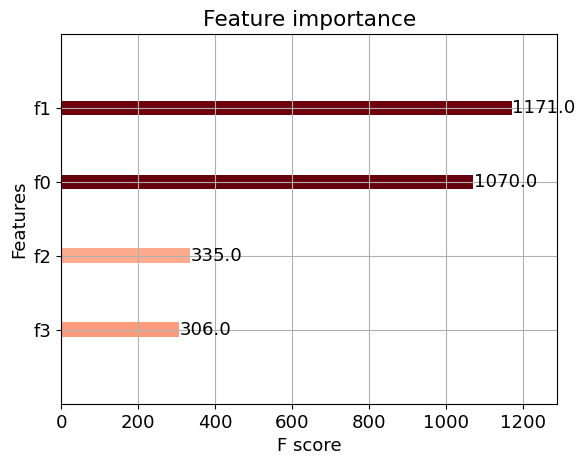

In [13]:
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
# feature importance

print(model.importance_type)
print(model.feature_importances_)
# plot
my_cmap = plt.get_cmap("Reds")
rescale = lambda y: 0.3 + 0.7 * (y - np.min(y)) / (np.max(y) - np.min(y))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_,
        color=my_cmap(rescale(model.feature_importances_)))
plt.xlabel("feature")
plt.ylabel("importance")
plt.xticks(np.arange(L))
plt.title(model.importance_type)
plt.show()

rescale_r = lambda y: 0.3 + 0.7 * (np.max(y) - y) / (np.max(y) - np.min(y))
plot_importance(model,color=my_cmap(rescale_r(model.feature_importances_)))
plt.show()

0 weight [1070. 1171.  335.  306.]
1 gain [3.84043241 4.06064796 0.6006853  0.66321445]
2 total_gain [4109.26269531 4755.01855469  201.22956848  202.94361877]
3 cover [73.71099854 66.86531067 77.84243011 62.61100388]
4 total_cover [78870.765625   78299.28125    26077.21289062 19158.96679688]


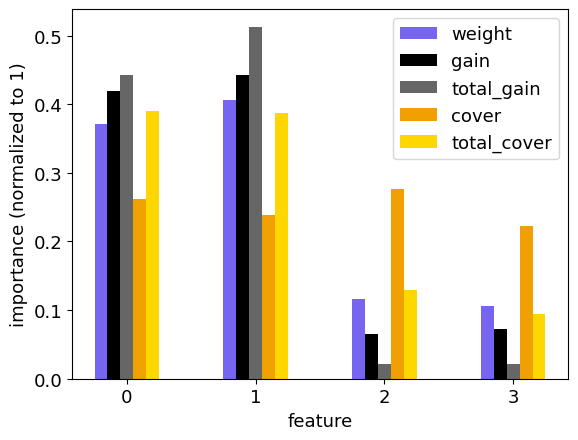

In [15]:
# if the importance type is “total_gain”, then the score is sum of loss change for each split from all trees.
list_type=["weight","gain","total_gain","cover","total_cover"]
list_col=["#7565F0","k","#666666","#F0A000","gold"]

for i,t in enumerate(list_type):
    feature_imp = model.get_booster().get_score(importance_type=t)
    keys = list(feature_imp.keys())
    values = np.array(list(feature_imp.values()))
    print(i,t,values)
    values= values/np.sum(values)
    plt.bar(np.arange(L)+(i-L/2)/10, values,color=list_col[i],width=0.1,label=t)
plt.xlabel("feature")
plt.ylabel("importance (normalized to 1)")
plt.xticks(np.arange(L))
plt.legend()
plt.show()

# Point 2

"Consider reduced data samples with L’<L features. For example, feature 0,1, and 3 out of the L=4 
features.  Check if the exclusion of the least important feature(s) from training data leads to better accuracy".

To answer this question we repeat the clustering and analyse its accuracy after having removed the least meaningful feature, and another time removing also the second-last one witth respect to each of the 'importance_type' types. For this dataset we already know that all the 'importance_type' types, except 'cover', consider 'more important' the first two features of the dataset; we still iterate over all the 'importance types' to increase the generality of the code (<-->if we were to use a different dataset).

In [ ]:
# Store feature importance values in a dictionary
importance_dict = {}
for i, t in enumerate(list_type):
    feature_imp = model.get_booster().get_score(importance_type=t)
    values = np.array([feature_imp.get(f'f{j}', 0) for j in range(L)])  # Ensure all features are included
    importance_dict[t] = values / np.sum(values)  # Normalize

accuracy_results_reduced = {}
accuracy_results_reduced_2 = {}

acc_full = model.score(x_test, y_test)
print("Accuracy with full features: {:.5f}".format(acc_full))

# Perform classification and feature reduction for each valid importance type
for imp_type in importance_dict.keys():
    print(f"\nProcessing importance type: {imp_type}")
    importances = importance_dict[imp_type]
    
    # Remove least important feature
    least_imp_feature = np.argmin(importances)
    x_train_reduced = np.delete(x_train, least_imp_feature, axis=1)
    x_test_reduced = np.delete(x_test, least_imp_feature, axis=1)
    
    model_reduced = XGBClassifier(seed=1, objective='binary:logistic', importance_type=imp_type)
    model_reduced.fit(x_train_reduced, y_train)
    acc_reduced = model_reduced.score(x_test_reduced, y_test)
        
    if acc_reduced > acc_full:
        print("Excluding the least important features IMPROVED accuracy, and infact:")
    else:
        print("Excluding the least important features did NOT improve accuracy, and infact:")

    classify(x_train_reduced, y_train, x_test_reduced, y_test, 3, model_reduced, show=False)
    
    # Remove two least important features
    least_imp_features_2 = np.argsort(importances)[:2]
    
    x_train_reduced_2 = np.delete(x_train, least_imp_features_2, axis=1)
    x_test_reduced_2 = np.delete(x_test, least_imp_features_2, axis=1)

    model_reduced_2 = XGBClassifier(seed=1, objective='binary:logistic', importance_type=imp_type)
    model_reduced_2.fit(x_train_reduced_2, y_train)
    acc_reduced_2 = model_reduced_2.score(x_test_reduced_2, y_test)
       
    if acc_reduced_2 > acc_full:
        print("Excluding the second least important features IMPROVED accuracy, and infact:")
    else:
        print("Excluding also the second least important features did NOT improve accuracy, and infact:")

    classify(x_train_reduced_2, y_train, x_test_reduced_2, y_test, 2, model_reduced_2, show=False)
    
    accuracy_results_reduced[imp_type] = (acc_reduced)
    accuracy_results_reduced_2[imp_type] = (acc_reduced_2)


plt.figure(figsize=(8, 5))
plt.axhline(y=acc_full, color='gray', linestyle='dashed', label='Full Feature Accuracy')
for i, (imp_type, accs) in enumerate(accuracy_results_reduced.items()):
    plt.scatter(i, accs, color='blue', label='Last removed' if i == 0 else "")
for i, (imp_type, accs) in enumerate(accuracy_results_reduced_2.items()):
    plt.scatter(i, accs, color='red', label='Second last Removed' if i == 0 else "")

plt.xticks(range(len(importance_dict.keys())), importance_dict.keys(), rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Importance Type')
plt.legend()
plt.title('Accuracy for Different Feature Importance Types')
plt.show()


Wich is obviously compatible with what can be seen from the plot:

In [ ]:
# if the importance type is “total_gain”, then the score is sum of loss change for each split from all trees.
list_type=["weight","gain","total_gain","cover","total_cover"]
list_col=["#7565F0","k","#666666","#F0A000","gold"]

for i,t in enumerate(list_type):
    feature_imp = model.get_booster().get_score(importance_type=t)
    keys = list(feature_imp.keys())
    values = np.array(list(feature_imp.values()))
    print(i,t,values)
    values= values/np.sum(values)
    plt.bar(np.arange(L)+(i-L/2)/10, values,color=list_col[i],width=0.1,label=t)
plt.xlabel("feature")
plt.ylabel("importance (normalized to 1)")
plt.xticks(np.arange(L))
plt.legend()
plt.show()

To make a comparison, the same thing is done by eliminating the second most important component, and then the first one (but having 'reintroduced' the second one).

In [ ]:
accuracy_results_reduced = {}
accuracy_results_reduced_2 = {}

print("Accuracy with full features: {:.3f}".format(acc_full))

# Perform classification and feature reduction for each valid importance type
for imp_type in importance_dict.keys():
    print(f"\nProcessing importance type: {imp_type}")
    importances = importance_dict[imp_type]

    # Remove least important feature
    least_imp_feature = np.argmax(importances)
    x_train_reduced = np.delete(x_train, least_imp_feature, axis=1)
    x_test_reduced = np.delete(x_test, least_imp_feature, axis=1)
    
    model_reduced = XGBClassifier(seed=1, objective='binary:logistic', importance_type=imp_type)
    model_reduced.fit(x_train_reduced, y_train)
    acc_reduced = model_reduced.score(x_test_reduced, y_test)
    
    if acc_reduced > acc_full:
        print("Excluding the first most important feature improved accuracy and infact:")
    else:
        print("Excluding the first most important feature did NOT improve accuracy and infact:")

    classify(x_train_reduced, y_train, x_test_reduced, y_test, 3, model_reduced, show=False) 
    
    # Remove two least important features
    least_imp_features_2 = np.argsort(importances)[-2]
    print(f"Index of the second most important feature:{least_imp_features_2}")
    x_train_reduced_2 = np.delete(x_train, least_imp_features_2, axis=1)
    x_test_reduced_2 = np.delete(x_test, least_imp_features_2, axis=1)
    y_train_reduced_2 = np.delete(y_train, least_imp_feature)
    y_test_reduced_2 = np.delete(y_test, least_imp_feature)
  
    model_reduced_2 = XGBClassifier(seed=1, objective='binary:logistic', importance_type=imp_type)
    model_reduced_2.fit(x_train_reduced_2, y_train)
    acc_reduced_2 = model_reduced_2.score(x_test_reduced_2, y_test)
   
    if acc_reduced_2 > acc_full:
        print("Excluding the second most important features IMPROVED accuracy, and infact:")
    else:
        print("Excluding second most important features did NOT improve accuracy, and infact:")

    classify(x_train_reduced_2, y_train, x_test_reduced_2, y_test, 3, model_reduced_2, show=False) 
    
    # Store results for plotting
    accuracy_results_reduced[imp_type] = (acc_reduced)
    accuracy_results_reduced_2[imp_type] = (acc_reduced_2)



plt.figure(figsize=(8, 5))
plt.axhline(y=acc_full, color='gray', linestyle='dashed', label='Full Feature Accuracy')
for i, (imp_type, accs) in enumerate(accuracy_results_reduced.items()):
    plt.scatter(i, accs, color='blue', label='First removed' if i == 0 else "")
for i, (imp_type, accs) in enumerate(accuracy_results_reduced_2.items()):
    plt.scatter(i, accs, color='red', label='Second Removed' if i == 0 else "")

plt.xticks(range(len(importance_dict.keys())), importance_dict.keys(), rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Importance Type')
plt.legend()
plt.title('Accuracy for Different Feature Importance Types')
plt.show()



So the curious thing is that deleting the one of the 'useless' fetures does not cause the model to perform better; it actually performs slightly worse. Instead, obviously, doing the clustering using just the two actual features gives the best performances. This may be due to the fact that the presence of multiple noisy features may help the ensemble average out variability. Infact the signal itself is random so the noise may dilute spurious data points. Or, instead, with more noisy features the model becomes actually able to 'learn' ehat noise is and therefore better ignoring it in the classification process. To see if this last observation holds let's try to ADD two more pure noise features (of the same kind of the previous ones) to the data and let's see if the result we get is bettern than the one we got with 4 total features.

In [ ]:
str0="_XGB_6_25.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x6 = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y6 = np.loadtxt(fnamey)
y6 = y6.astype(int)
N,L = len(x6), len(x6[0])

N_train = int(0.75*N)
x_train6,y_train6 = x6[:N_train],y6[:N_train]
x_test6,y_test6 = x6[N_train:],y6[N_train:]
print(f"N={N}, N_train={N_train}, L={L}")


model6 = XGBClassifier(seed=1, objective='binary:logistic', importance_type='gain')
model6.fit(x_train6, y_train6)
acc = model6.score(x_test6, y_test6)
print("Accuracy with full features: {:.3f}".format(acc))
classify(x_train6, y_train6, x_test6, y_test6, L, model6, show=False) 

So the classification doesn't get better than the one that uses 4 features with 2 noisy ones, however it doesn't get much worse. However using L=5 (so in total 3 noisy featuers) gives results that are a little WORSE than those we get using L=6.

## normal Gradient Boosting

In [ ]:
# GradientBoostingClassifier()
classify()

#However its is not refined, maybe we can get a little better results than this but not as good as xgboost

## AdaBoost

In [ ]:
classify(clf=AdaBoostClassifier(learning_rate=.8,n_estimators=150))

## XGBOOST vs FFNN

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import time


In [27]:
def build_nn_model(x_train, y_train, x_val, y_val, epochs=100):  
    start_time = time.time()

    y_train_encoded = to_categorical(y_train)
    y_val_encoded = to_categorical(y_val)
    output_dim = len(np.unique(y_train))

    nn_model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-6)),  
        Dropout(0.2),
        Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-6)),  
        Dropout(0.2),
        Dense(output_dim, activation='softmax', kernel_regularizer=keras.regularizers.l2(1e-6))
    ])

    nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    nn_model.fit(x_train, y_train_encoded, epochs=epochs, verbose=0, validation_data=(x_val, y_val_encoded))  

    accuracy = nn_model.evaluate(x_val, y_val_encoded, verbose=0)[1]
    execution_time = time.time() - start_time

    print(f"Neural Network Performance: Accuracy = {accuracy:.3f}, Training Time = {execution_time:.2f} s")
    return accuracy

In [29]:
def build_xgb_model(x_train, y_train, x_val, y_val):  
    start_time = time.time()

    xgb_model = XGBClassifier(seed=1, objective='binary:logistic', gamma=0.1, 
                              learning_rate=0.15, max_depth=6, n_estimators=30,  
                              n_jobs=-1)  
    xgb_model.fit(x_train, y_train)
    accuracy = xgb_model.score(x_val, y_val)

    execution_time = time.time() - start_time
    print(f'XGBoost Performance: Accuracy = {accuracy:.3f}, Training Time = {execution_time:.2f} s')
    return accuracy

In [31]:
validation_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
num_samples = x.shape[0]
indices = np.arange(num_samples)

accuracy_scores, std_devs, training_times = [], [], []

for ratio in validation_ratios:
    fold_accuracies = []

    for fold in range(3):  
        num_train_samples = int((1 - ratio) * num_samples)
        num_val_samples = num_samples - num_train_samples

        val_indices = np.random.choice(indices, num_val_samples, replace=False)
        x_val, y_val = x[val_indices], y[val_indices]
        x_train, y_train = np.delete(x, val_indices, axis=0), np.delete(y, val_indices)

        print(f'--- Fold {fold + 1}/3 ---')
        print(f'Validation Set Size: {ratio * 100:.1f}% ({num_val_samples} samples)')

        nn_start = time.time()
        nn_accuracy = build_nn_model(x_train, y_train, x_val, y_val)
        nn_end = time.time()

        xgb_start = time.time()
        xgb_accuracy = build_xgb_model(x_train, y_train, x_val, y_val)
        xgb_end = time.time()

        fold_accuracies.append([nn_accuracy, xgb_accuracy])
        training_times.append([nn_end - nn_start, xgb_end - xgb_start])

    accuracy_scores.append(np.mean(fold_accuracies, axis=0))
    std_devs.append(np.std(fold_accuracies, axis=0))

accuracy_scores = np.array(accuracy_scores)
std_devs = np.array(std_devs)
training_times = np.array(training_times)

--- Fold 1/3 ---
Validation Set Size: 10.0% (500 samples)
Neural Network Performance: Accuracy = 0.578, Training Time = 28.81 s
XGBoost Performance: Accuracy = 0.900, Training Time = 0.04 s
--- Fold 2/3 ---
Validation Set Size: 10.0% (500 samples)
Neural Network Performance: Accuracy = 0.578, Training Time = 29.53 s
XGBoost Performance: Accuracy = 0.918, Training Time = 0.03 s
--- Fold 3/3 ---
Validation Set Size: 10.0% (500 samples)
Neural Network Performance: Accuracy = 0.588, Training Time = 32.06 s
XGBoost Performance: Accuracy = 0.922, Training Time = 0.04 s
--- Fold 1/3 ---
Validation Set Size: 20.0% (1000 samples)
Neural Network Performance: Accuracy = 0.538, Training Time = 31.44 s
XGBoost Performance: Accuracy = 0.886, Training Time = 0.04 s
--- Fold 2/3 ---
Validation Set Size: 20.0% (1000 samples)
Neural Network Performance: Accuracy = 0.555, Training Time = 30.21 s
XGBoost Performance: Accuracy = 0.884, Training Time = 0.03 s
--- Fold 3/3 ---
Validation Set Size: 20.0% (100

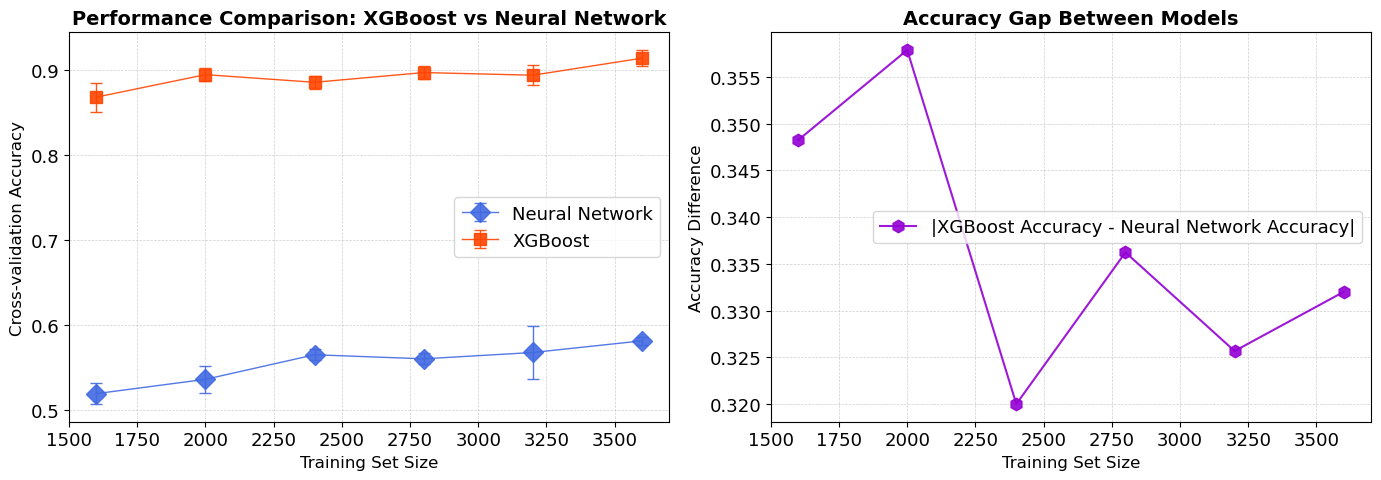

In [35]:
average_time = np.mean(training_times, axis=0)
train_sizes = [3600, 3200, 2800, 2400, 2000, 1600]


fig, ax = plt.subplots(1, 2, figsize=(14, 5))


ax[0].errorbar(train_sizes, accuracy_scores[:, 0], std_devs[:, 0], label='Neural Network', 
               marker='D', linewidth=1, color='royalblue', markersize=10, capsize=4, alpha=0.9)
ax[0].errorbar(train_sizes, accuracy_scores[:, 1], std_devs[:, 1], label='XGBoost', 
               marker='s', linewidth=1, color='orangered', markersize=8, capsize=4, alpha=0.9)

ax[0].set_title('Performance Comparison: XGBoost vs Neural Network', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Training Set Size', fontsize=12)
ax[0].set_ylabel('Cross-validation Accuracy', fontsize=12)
ax[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
ax[0].legend(fontsize='medium', loc='best')


ax[1].plot(train_sizes, accuracy_scores[:, 1] - accuracy_scores[:, 0], marker='h', 
           label='|XGBoost Accuracy - Neural Network Accuracy|', linewidth=1.5, color='darkviolet', markersize=9, alpha=0.9)

ax[1].set_title('Accuracy Gap Between Models', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Training Set Size', fontsize=12)
ax[1].set_ylabel('Accuracy Difference', fontsize=12)
ax[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
ax[1].legend(fontsize='medium', loc='best')


plt.tight_layout()
plt.savefig("XGBoost_vs_NN_Performance.pdf", format="pdf", bbox_inches="tight")
plt.show()

We compared the validation accuracy of XGBoost and a simple Feed-Forward Neural Network (FFNN) while varying the training set size. The results clearly indicate that XGBoost significantly outperforms FFNN, achieving an accuracy close to 0.9, whereas the FFNN lags behind at approximately 0.55. This difference arises because XGBoost is highly robust even with smaller datasets, whereas FFNN struggles to generalize unless trained on large volumes of data. As the training set size increases, both models show slight improvements in accuracy. 